In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random
from google.colab import drive
from google.colab import files
import shutil

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from numpy.random import seed
import pickle
seed(1)
tf.random.set_seed(1)

In [ ]:
# mount drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
root_path = "/content/drive/Shareddrives/[Deep Learning Project]"
dataset_dir = os.path.join(root_path, "Dataset")
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')

Print some samples

/content/drive/Shareddrives/[Deep Learning Project]/Dataset/train
/content/drive/Shareddrives/[Deep Learning Project]/Dataset/train/Edgar Degas
/content/drive/Shareddrives/[Deep Learning Project]/Dataset/train/Edgar Degas/Edgar_Degas_113.jpg


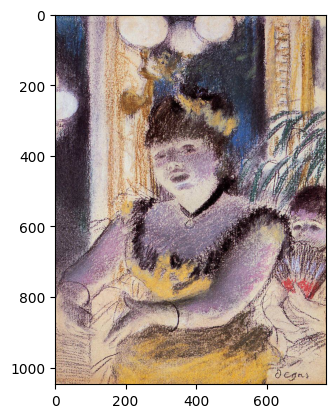

In [ ]:
from PIL import Image
from matplotlib.pyplot import imshow

print(train_dir)
example_artist_dir = os.path.join(train_dir,os.listdir(train_dir)[0])
print(example_artist_dir)
example_img = os.path.join(example_artist_dir,os.listdir(example_artist_dir)[0])
print(example_img)
image = Image.open(example_img,'r')
imshow(image)

In [ ]:
artists = pd.read_csv('/content/drive/Shareddrives/[Deep Learning Project]/Dataset/artists150.csv')

#Since the classes are ordered in the same way as the directories in the
# test directory, so ordered by name, we need to retrieve the weights in
# the same order
artists = artists.sort_values("name")
print(artists)

#Convert the column to an array containing the weights
class_weight = artists["weight"].to_numpy()
print(class_weight)

#Then we need a dictionary with a number as a key and the weight as value
class_weight = {i : class_weight[i] for i in range(len(class_weight))}
print(class_weight)

                     name                                    genre  paintings  \
7          Albrecht Dürer                     Northern Renaissance        328   
8           Alfred Sisley                            Impressionism        259   
0       Amedeo Modigliani                            Expressionism        193   
16            Andy Warhol                                  Pop Art        181   
12            Edgar Degas                            Impressionism        702   
6          Francisco Goya                              Romanticism        291   
11          Henri Matisse         Impressionism,Post-Impressionism        186   
9            Marc Chagall                              Primitivism        239   
3          Mikhail Vrubel                                Symbolism        171   
4           Pablo Picasso                                   Cubism        439   
17           Paul Gauguin             Symbolism,Post-Impressionism        311   
15              Paul Klee  E

#BUILDING THE NETWORK

To see the choices taken see the report.

In [ ]:
from tensorflow.keras import layers

classes = list(os.listdir(train_dir))

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, strides=1 , activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, strides=1, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, strides=1, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, strides=1, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, strides=1, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(18, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

In [ ]:
from tensorflow.keras import optimizers

#As optimizer we've selected Adam since is the suggested one for multiclass
# classification
optimizer = keras.optimizers.Adam(learning_rate=1e-3)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:
#Set the parameter used to load the dataset
BATCH_SIZE = 64
IMAGE_HEIGHT = 180
IMAGE_WIDTH = 180

#Creation of the training, validation and test set

We exploit the directory hierarchy of our dataset to infer the classes from the
name of the directories, more details are present in the report about the choices taken.

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    train_dir,
    labels='inferred', 
    label_mode='categorical',
    class_names=None, 
    shuffle=True,
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="training",
    seed=1024)

validation_dataset = image_dataset_from_directory(
    train_dir,
    labels='inferred', 
    label_mode='categorical',
    class_names=None, 
    shuffle=True,
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="validation",
    seed=1024)

test_dataset = image_dataset_from_directory(
    test_dir,
    labels='inferred', 
    label_mode='categorical',
    shuffle=True,
    class_names=None, 
    color_mode='rgb',
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)


# train_dataset_reduction = image_dataset_from_directory(
#     train_dir,
#     labels='inferred', 
#     label_mode='categorical',
#     class_names=None, 
#     color_mode='rgb',
#     image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
#     batch_size=BATCH_SIZE,
#     validation_split=0.8,
#     subset="training",
#     seed=2000)


# validation_dataset_reduction = image_dataset_from_directory(
#     train_dir,
#     labels='inferred', 
#     label_mode='categorical',
#     class_names=None, 
#     color_mode='rgb',
#     image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
#     batch_size=BATCH_SIZE,
#     validation_split=0.02,
#     subset="validation",
#     seed=2000)

Found 4452 files belonging to 18 classes.
Using 3562 files for training.
Found 4452 files belonging to 18 classes.
Using 890 files for validation.
Found 1112 files belonging to 18 classes.


In [ ]:
#for data_batch, labels_batch in train_dataset:
 #   print('data batch shape:', data_batch.shape)
  #  print('labels batch shape:', labels_batch.shape)
   # break

#Train the network

In the following cell the training procedure is started, we've passed the 
training set, the number of epochs, the validation split and in this case we've
exploited the *class_weights* to cope with the imbalanced dataset. 

In [ ]:
history = model.fit(
  train_dataset,
  epochs=25,
  validation_data=validation_dataset,
  class_weight = class_weight)

Epoch 1/25
56/56 [==============================] - 692s 11s/step - loss: 2.8020 - accuracy: 0.0980 - val_loss: 2.6675 - val_accuracy: 0.1517
Epoch 2/25
56/56 [==============================] - 30s 496ms/step - loss: 2.5715 - accuracy: 0.1819 - val_loss: 2.5644 - val_accuracy: 0.1888
Epoch 3/25
56/56 [==============================] - 28s 458ms/step - loss: 2.3486 - accuracy: 0.2333 - val_loss: 2.3442 - val_accuracy: 0.2640
Epoch 4/25
56/56 [==============================] - 29s 470ms/step - loss: 2.1872 - accuracy: 0.2858 - val_loss: 2.3206 - val_accuracy: 0.2719
Epoch 5/25
56/56 [==============================] - 28s 461ms/step - loss: 2.0472 - accuracy: 0.3254 - val_loss: 2.1725 - val_accuracy: 0.3079
Epoch 6/25
56/56 [==============================] - 29s 465ms/step - loss: 1.9360 - accuracy: 0.3543 - val_loss: 2.0182 - val_accuracy: 0.3596
Epoch 7/25
56/56 [==============================] - 28s 458ms/step - loss: 1.8307 - accuracy: 0.3942 - val_loss: 2.0354 - val_accuracy: 0.3730


**Results of the training phase**

In the following cell we've obtained the plots of the accuracy and loss for both
the training and validation set.

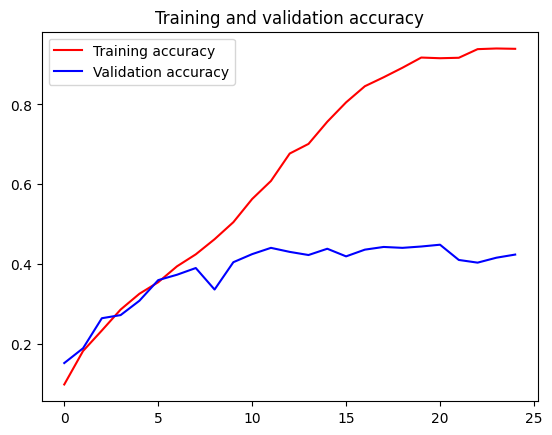

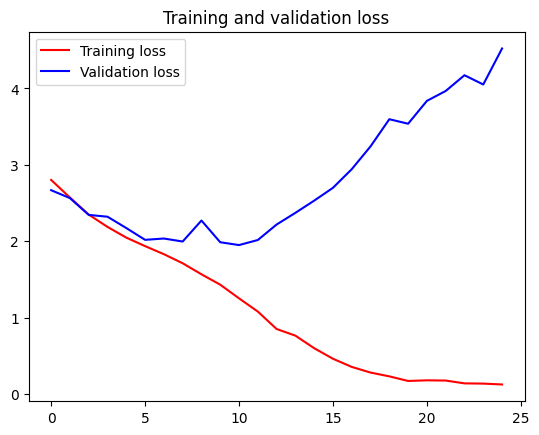

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Evaluation of the model
In the following cells we've evaluated the model exploting the test set, obtaining its loss and accuracy.

In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset)

18/18 [==============================] - 176s 5s/step - loss: 4.9067 - accuracy: 0.4245


TypeError: ignored

In [ ]:
print("Loss: " + str(test_loss))
print("Accuracy: " + str(test_accuracy))

history.history["test_loss"] = test_loss
history.history["test_accuracy"] = test_accuracy

Loss: 4.9066667556762695
Accuracy: 0.42446044087409973


Save the model and its history in the models' folder

In [ ]:
dir_name = os.path.join(root_path, "Models")
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
model.save(os.path.join(dir_name, 'artistsRecognition1.h5'))
with open(os.path.join(dir_name, 'trainHistory'), 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [ ]:
#Construct the matrices for all these values!! Imbalanced dataset and weight doesn't works, se need to increment the number of images!

In [ ]:
#WE HAVE OVERFITTING: 

# Steps for reducing overfitting:

# Add more data
# Use data augmentation
# Use architectures that generalize well
# Add regularization (mostly dropout, L1/L2 regularization are also possible)
# # Reduce architecture complexity.
# minority class is equal to or fewer than 20% of the number of samples in the 
# majority class -> use data augmentation to double the minority class samples! 